# Online Shoppers Purchasing Intention Analysis
https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset

# STEP 0 : Importing libraries and files

In [91]:
# Importing the libraries
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Importing the dataset
data = pd.read_csv("online_shoppers_intention.csv", header = 0)

# STEP 1 : Data Cleaning (if necessary)

In [92]:
data.dtypes

Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object

In [93]:
# Month and VisitorType are object type, checking for missing values
print(data['Month'].value_counts())
print(data['VisitorType'].value_counts())

May     3364
Nov     2998
Mar     1907
Dec     1727
Oct      549
Sep      448
Aug      433
Jul      432
June     288
Feb      184
Name: Month, dtype: int64
Returning_Visitor    10551
New_Visitor           1694
Other                   85
Name: VisitorType, dtype: int64


# STEP 2 : Data preprocessing

In [94]:
# Categorical features encoder
column_trans = make_column_transformer((OneHotEncoder(),['Month','OperatingSystems','Browser','VisitorType','Weekend']),remainder='passthrough')

# Scaler
scalar = MinMaxScaler()

# Purchased
dataset_p = data[data.Revenue==True]
# Not Purchased
dataset_np = data[data.Revenue==False]

# Downsampled Dataset
dataset_p_down = resample(dataset_p,replace=False,n_samples=1000)
dataset_np_down = resample(dataset_np,replace=False,n_samples=5000)
dataset = pd.concat([dataset_p_down,dataset_np_down])

# Identifying the class label
X = dataset.drop(columns=['Revenue'])
y = dataset['Revenue']

# Encoding categorical features
column_trans.fit(X)
X = column_trans.transform(X)

# Creating training and testing set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=0)

# Center and normalize the data
scalar.fit(X)
X_train = scalar.transform(X_train)
X_test = scalar.transform(X_test)

# STEP 3 : Data Visualisation

## Features correlation matrix

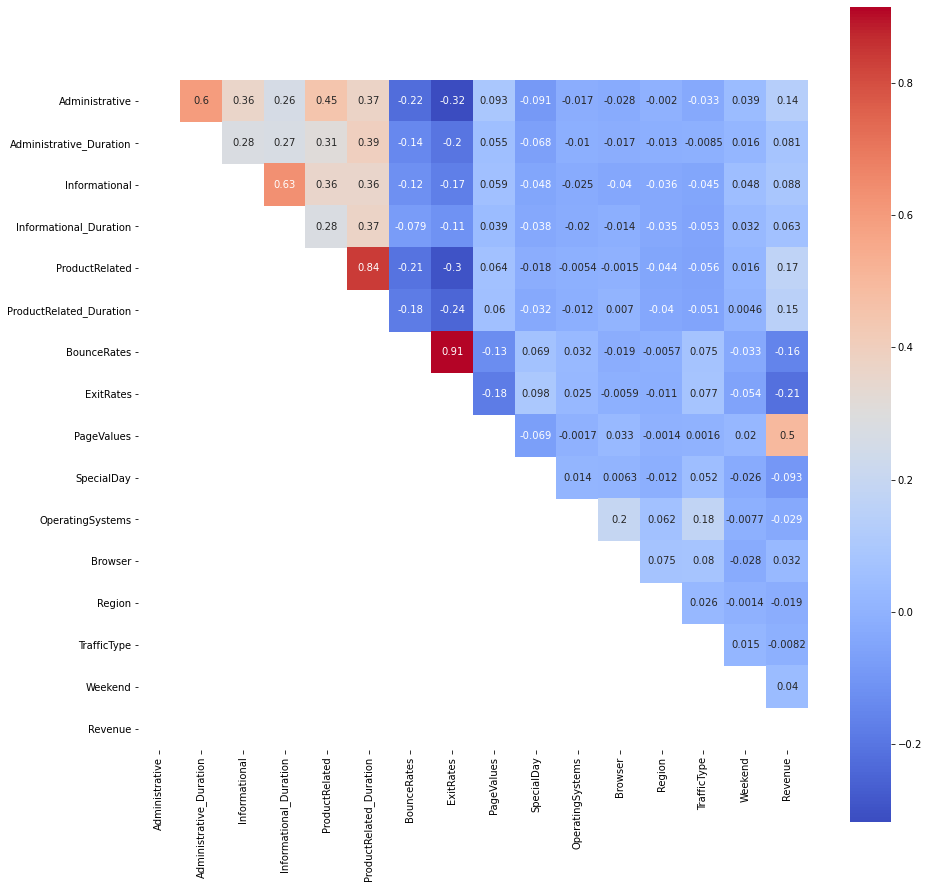

In [95]:
plt.subplots(figsize=(15,15))
matrix = np.tril(data.corr())
sns.heatmap(dataset.corr(), annot = True, cmap= 'coolwarm',square=True,mask = matrix)

## Principal Component Analysis

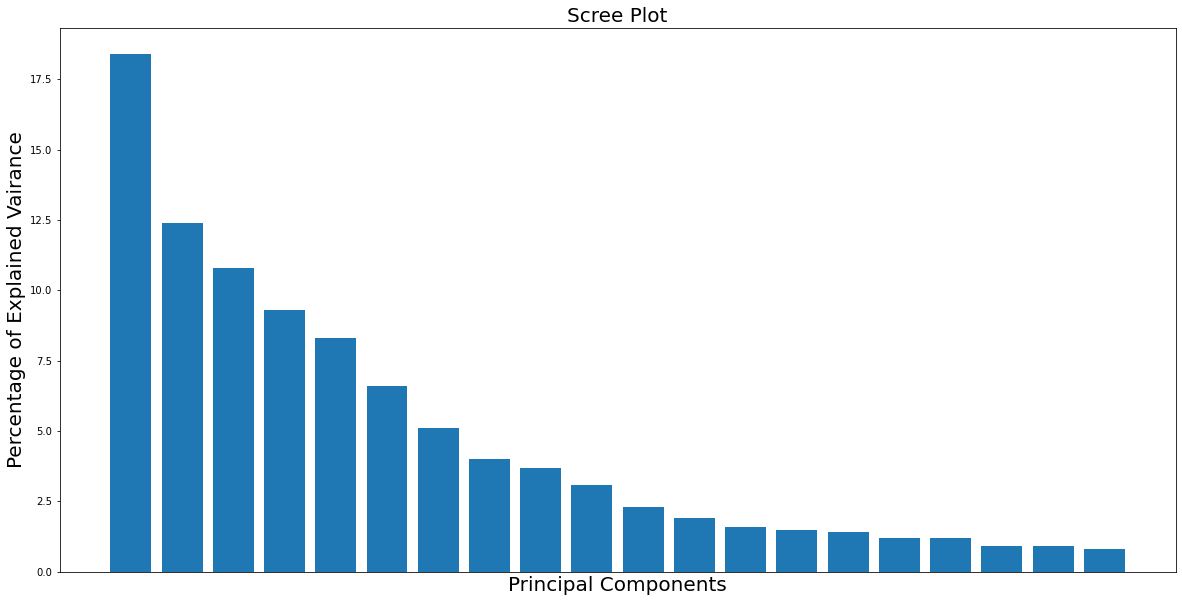

In [79]:
#Showing the first 20 most important axes
pca = PCA(n_components=20)
X_train_pca = pca.fit_transform(X_train)
per_var = np.round(pca.explained_variance_ratio_*100,decimals=1)
labels = [str(x) for x in range(1,len(per_var)+1)]
plt.rcParams['figure.figsize'] = (20, 10)
font=20
plt.bar(x=range(1,len(per_var)+1),height=per_var)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.ylabel('Percentage of Explained Vairance', fontsize = font)
plt.xlabel('Principal Components', fontsize = font)
plt.title('Scree Plot', fontsize = font)
plt.show()

## 2D PCA Plot

In [80]:
print('explained variance ratio (first three components): %s'
      % str(pca.explained_variance_ratio_))

explained variance ratio (first three components): [0.18414715 0.1243419  0.10791808 0.09342948 0.08340238 0.06636143
 0.0510415  0.03965462 0.03714252 0.03055791 0.02301509 0.01872133
 0.01640817 0.01532138 0.01387221 0.01218126 0.01191323 0.00949777
 0.00935348 0.00814264]


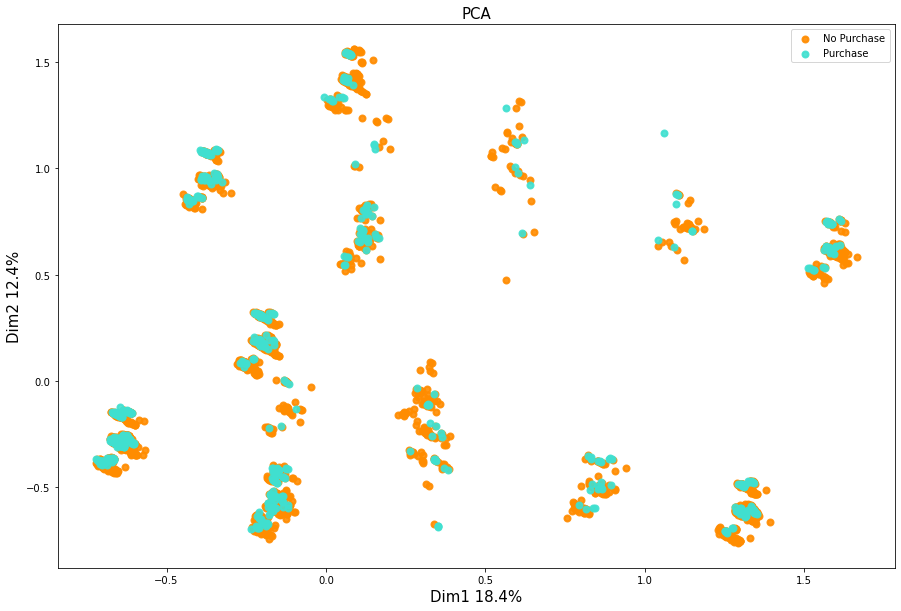

In [82]:
X_r = pca.fit(X_train).transform(X_train)

plt.figure()

colors = ['darkorange', 'turquoise']
lw = 2

target_names= ["No Purchase","Purchase"]

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y_train == i, 0], X_r[y_train == i, 1], color=color, alpha=.9, lw=lw,
                label=target_name)

font=15
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA',fontsize=font)
pca100 = pca.explained_variance_ratio_
D1 = "Dim1 " + str(round(pca100[0] * 100,1)) + "%"
D2 = "Dim2 " + str(round(pca100[1] * 100,1)) + "%"
plt.ylabel(D2,fontsize=font)
plt.xlabel(D1,fontsize=font)
plt.rcParams['figure.figsize'] = (15, 10)
plt.show()

## Univariate Analysis

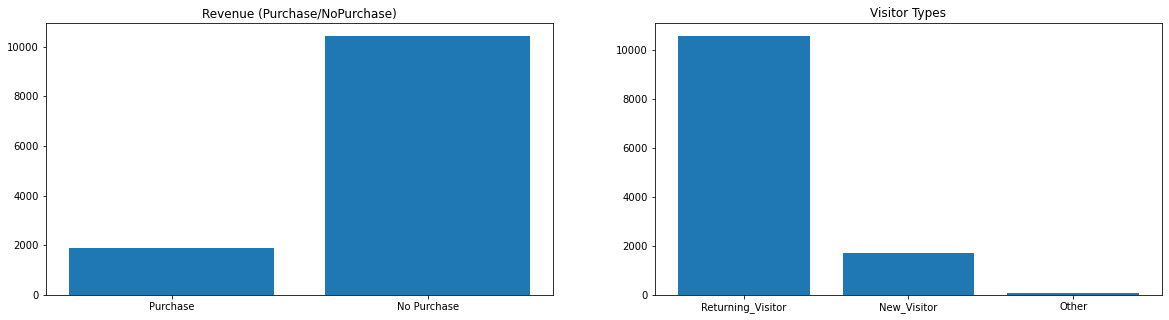

In [83]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches(20,5)

#Visitor Types
axs[1].set_title("Visitor Types")
Vtype = ['Returning_Visitor','New_Visitor','Other']
count_vtype = [data['VisitorType'].value_counts()['Returning_Visitor'],
               data['VisitorType'].value_counts()['New_Visitor'],
               data['VisitorType'].value_counts()['Other']]
axs[1].bar(Vtype,count_vtype)

#Number of Purchased
axs[0].set_title("Revenue (Purchase/NoPurchase)")
TF = ["Purchase","No Purchase"]
TF_count = [data['Revenue'].value_counts()[True],data['Revenue'].value_counts()[False]]
axs[0].bar(TF,TF_count)

plt.show()

Text(0.5, 1.0, 'Number of Purchase each month')

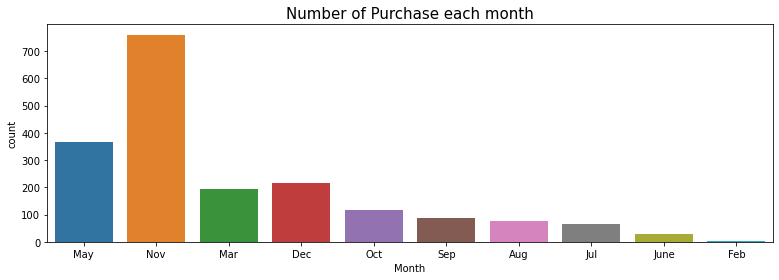

In [84]:
plt.figure(figsize=(13, 4))
sns.countplot(dataset_p.Month.dropna(), order = data.Month.value_counts().index);
plt.title('Number of Purchase each month', fontsize = 15)

Text(0.5, 1.0, 'Number of No Purchase each month')

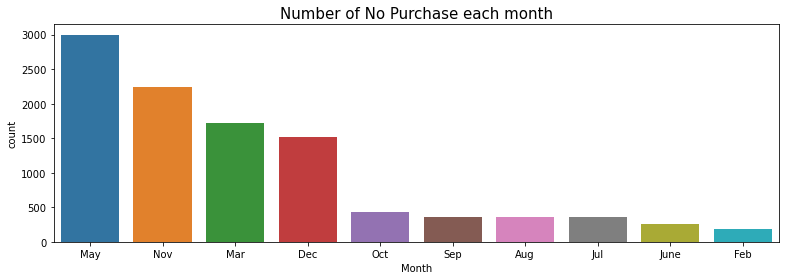

In [85]:
plt.figure(figsize=(13, 4))
sns.countplot(dataset_np.Month.dropna(), order = data.Month.value_counts().index);
plt.title('Number of No Purchase each month', fontsize = 15)

## Bivariate analysis

### Exit rate by Revenue (Purchase/NoPurchase)

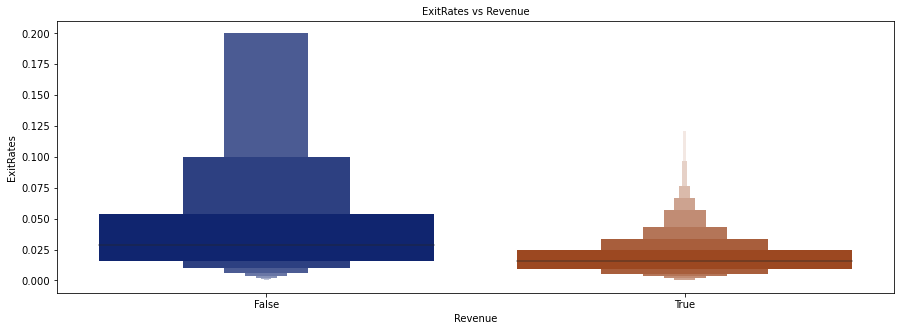

In [86]:
# product related duration vs revenue

plt.rcParams['figure.figsize'] = (15, 5)
# exit rate vs raevenue
sns.boxenplot(data['Revenue'], data['ExitRates'], palette = 'dark')
plt.title('ExitRates vs Revenue', fontsize = 10)
plt.xlabel('Revenue', fontsize = 10)
plt.ylabel('ExitRates', fontsize = 10)

plt.show()

### Revenue by visitor type

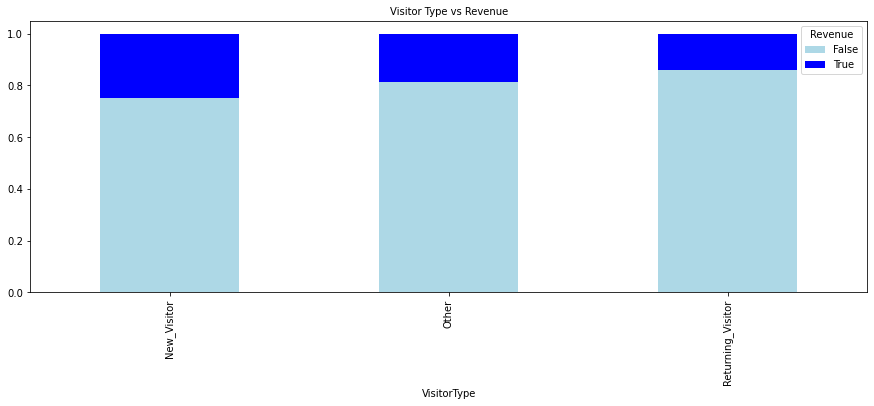

In [87]:
df = pd.crosstab(data['VisitorType'], data['Revenue'])
df.div(df.sum(1).astype(float), axis = 0).plot(kind = 'bar', stacked = True, figsize = (15, 5), color = ['lightblue', 'blue'])
plt.title('Visitor Type vs Revenue', fontsize = 10)
plt.show()

## Multivariate analysis

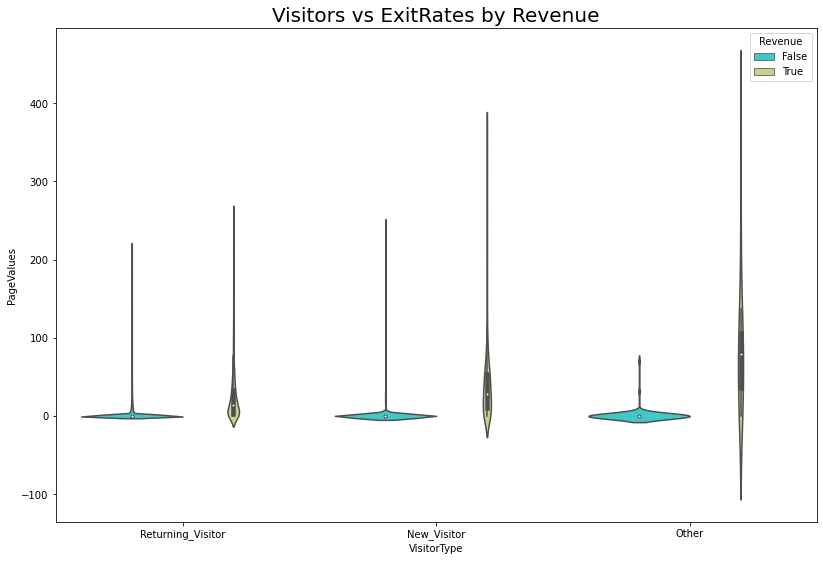

In [88]:
plt.rcParams['figure.figsize'] = (30, 20)
plt.subplot(2, 2, 1)
sns.violinplot(x = data['VisitorType'], y = data['PageValues'], hue = data['Revenue'], palette = 'rainbow')
plt.title('Visitors vs ExitRates by Revenue', fontsize = 20)

plt.show()

# STEP 4: Building ML Model

## Overview of a few model's performance

Naive Bayes 
 Accuracy: 0.288 
 f1 score 0.31007751937984496
Logistic Regression 
 Accuracy: 0.8633333333333333 
 f1 score 0.38066465256797577


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


K Nearest Neighbour 
 Accuracy: 0.8173333333333334 
 f1 score 0.20809248554913296
Support Vector Classification 
 Accuracy: 0.844 
 f1 score 0.13333333333333336
Decision Tree Classification 
 Accuracy: 0.87 
 f1 score 0.5962732919254659
Stochastic Gradient Descent 
 Accuracy: 0.8733333333333333 
 f1 score 0.48924731182795694
Linear Discriminant Analysis 
 Accuracy: 0.8693333333333333 
 f1 score 0.4759358288770054
Gradient Boosting Classification  
 Accuracy: 0.8966666666666666 
 f1 score 0.6593406593406593
Random Forest Classification 
 Accuracy: 0.896 
 f1 score 0.6303317535545023


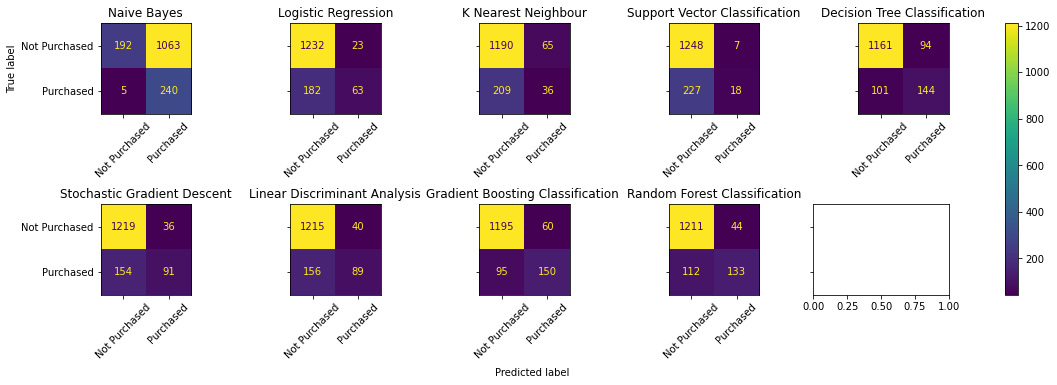

In [14]:
classifiers = {
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(),
    "K Nearest Neighbour": KNeighborsClassifier(),
    "Support Vector Classification": SVC(),
    "Decision Tree Classification": DecisionTreeClassifier(),
    "Stochastic Gradient Descent": SGDClassifier(),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
    "Gradient Boosting Classification ": GradientBoostingClassifier(),
    "Random Forest Classification": RandomForestClassifier()
    }

f, axes = plt.subplots(2, 5, figsize=(20, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    j = 0
    k = i
    if i>4:
        k = i-5
        j+=1
    
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    print(key, "\n Accuracy:",accuracy_score(y_test,y_pred),"\n f1 score",f1_score(y_test,y_pred))
    disp = ConfusionMatrixDisplay(cf_matrix,
                                  display_labels=["Not Purchased","Purchased"])
    disp.plot(ax=axes[j][k], xticks_rotation=45)
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

f.text(0.43, -0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=1)


f.colorbar(disp.im_, ax=axes)
plt.show()

# STEP 5 : Model Tuning (Grid Search)

## Gradient Boosting

In [15]:
parameters = [{
    "loss":["deviance"],
    "learning_rate": [0.2,0.3,0.4],
    "min_samples_split": [0.01,0.1, 0.5],
    "min_samples_leaf": [0.0001,0.001, 0.01],
    "max_depth":[8,10,15],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.7,0.8,0.9],
    "n_estimators":[10,20,30]
    }]
gbm = GridSearchCV(GradientBoostingClassifier(), parameters, cv=5, n_jobs=-1,scoring='f1', verbose=True)
gbm.fit(X_train,y_train)


Fitting 5 folds for each of 2916 candidates, totalling 14580 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 576 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 1276 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 2176 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 3276 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 4576 tasks      | elapsed:   59.3s
[Parallel(n_jobs=-1)]: Done 6076 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 7566 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 8516 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 9566 tasks      | elapsed: 19.9min
[Parallel(n_jobs=-1)]: Done 10716 tasks      | elapsed: 29.2min
[Parallel(n_jobs=-1)]: Done 11966 tasks      | elapsed: 39.6min
[Parallel(n_jobs=-1)]: Done 13316 tasks      | elapsed: 50.2min
[Parallel(n_jobs=-1)]: Done 14580 out of 

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid=[{'criterion': ['friedman_mse', 'mae'],
                          'learning_rate': [0.2, 0.3, 0.4],
                          'loss': ['deviance'], 'max_depth': [8, 10, 15],
                          'max_features': ['log2', 'sqrt'],
                          'min_samples_leaf': [0.0001, 0.001, 0.01],
                          'min_samples_split': [0.01, 0.1, 0.5],
                          'n_estimators': [10, 20, 30],
                          'subsample': [0.7, 0.8, 0.9]}],
             scoring='f1', verbose=True)

In [16]:
print(gbm.best_params_)

{'criterion': 'friedman_mse', 'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 0.0001, 'min_samples_split': 0.1, 'n_estimators': 30, 'subsample': 0.7}


In [18]:
# Gradient boosting with best parameters
gs_gbm = GradientBoostingClassifier( 
    criterion='friedman_mse',
    learning_rate=0.2,
    loss='deviance',
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf= 0.0001,
    min_samples_split= 0.1,
    n_estimators = 30,
    subsample = 0.7
)
gs_gbm.fit(X_train, y_train)
gs_gbm.score(X_test,y_test)

0.8926666666666667

## Stochastic gradient descent

In [18]:
parameters = [{
    "max_iter": [100,200,300],
    "loss": ["hinge","log","squared_hinge","perceptron"],
    "penalty": ["elasticnet", "l1", "l2"],
    "alpha": [0.0001, 0.001, 0.01, 0.1], 
    "learning_rate": ['constant', 'optimal', 'invscaling', 'adaptive'],
    "class_weight": [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}],
    "eta0": [1, 10] 
             }]
sgd = GridSearchCV(SGDClassifier(), parameters, cv=5, n_jobs=-1,scoring='f1', verbose=True)
sgd.fit(X_train,y_train)


Fitting 5 folds for each of 4608 candidates, totalling 23040 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 952 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 1828 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 3224 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 5024 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done 7292 tasks      | elapsed:   56.8s
[Parallel(n_jobs=-1)]: Done 9848 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 13368 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 16992 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 23040 out of 23040 | elapsed:  2.5min finished


GridSearchCV(cv=5, estimator=SGDClassifier(), n_jobs=-1,
             param_grid=[{'alpha': [0.0001, 0.001, 0.01, 0.1],
                          'class_weight': [{0: 0.5, 1: 0.5}, {0: 0.6, 1: 0.4},
                                           {0: 0.4, 1: 0.6}, {0: 0.3, 1: 0.7}],
                          'eta0': [1, 10],
                          'learning_rate': ['constant', 'optimal', 'invscaling',
                                            'adaptive'],
                          'loss': ['hinge', 'log', 'squared_hinge',
                                   'perceptron'],
                          'max_iter': [100, 200, 300],
                          'penalty': ['elasticnet', 'l1', 'l2']}],
             scoring='f1', verbose=True)

In [35]:
print(sgd.best_params_)

{'alpha': 0.001, 'class_weight': {1: 0.7, 0: 0.3}, 'eta0': 10, 'learning_rate': 'adaptive', 'loss': 'perceptron', 'max_iter': 300, 'penalty': 'elasticnet'}


In [19]:
# Stochastic gradient descent with best parameters
gs_sgd = SGDClassifier(alpha =0.001, 
                       class_weight ={1: 0.7, 0: 0.3}, 
                       eta0 =10, 
                       learning_rate = 'adaptive', 
                       loss= 'perceptron', 
                       max_iter=300, 
                       penalty= 'elasticnet')
gs_sgd.fit(X_train, y_train)
gs_sgd.score(X_test,y_test)

0.8846666666666667

## Random Forest

In [21]:
parameters = [{
    "criterion": ["gini",  "entropy"],
    "n_estimators": [200,400,600,800,1000],
    "max_features": ['auto', 'sqrt'],
    "max_depth": [5, 50, 100],
    "min_samples_split": [5,10,15,20,25,30], 
    "min_samples_leaf": [1,5,10,15,20],
    "bootstrap": [True, False]
             }]

rf = GridSearchCV(RandomForestClassifier(), 
                  parameters, 
                  cv=5, 
                  n_jobs=-1,
                  scoring='f1', 
                  verbose=True)

rf.fit(X_train,y_train)

Fitting 5 folds for each of 3600 candidates, totalling 18000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 23.2min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed: 28.4min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed: 34.0min
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed: 41.6min
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed: 49.7min
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed: 57.3min
[Parallel(n_jobs=-1)]: Done 11226 tasks      

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'bootstrap': [True, False],
                          'criterion': ['gini', 'entropy'],
                          'max_depth': [5, 50, 100],
                          'max_features': ['auto', 'sqrt'],
                          'min_samples_leaf': [1, 5, 10, 15, 20],
                          'min_samples_split': [5, 10, 15, 20, 25, 30],
                          'n_estimators': [200, 400, 600, 800, 1000]}],
             scoring='f1', verbose=True)

In [40]:
print(rf.best_params_)

{'bootstrap': False, 'criterion': 'entropy', 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 25, 'n_estimators': 800}


In [20]:
# Random forest with best parameters
gs_rf = RandomForestClassifier(bootstrap=False,
                               criterion='entropy',
                               max_depth= 100, 
                               max_features='sqrt', 
                               min_samples_leaf=1, 
                               min_samples_split=25, 
                               n_estimators=800)
gs_rf.fit(X_train, y_train)
gs_rf.score(X_test,y_test)

0.9

## Decision Tree

In [24]:
parameters = [{
    "criterion": ['gini','entropy'],
    "max_depth": range(1,10),
    "min_samples_split": range(1,10), 
    "min_samples_leaf": [1,2,5,10],
             }]

dt = GridSearchCV(DecisionTreeClassifier(),
                  parameters, 
                  cv=5, n_jobs=-1,
                  scoring='f1', 
                  verbose=True)

dt.fit(X_train,y_train)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed:    6.2s finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': range(1, 10),
                          'min_samples_leaf': [1, 2, 5, 10],
                          'min_samples_split': range(1, 10)}],
             scoring='f1', verbose=True)

In [43]:
print(dt.best_params_)

{'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [21]:
# Decision Tree with best parameters
gs_dt = DecisionTreeClassifier(criterion='gini', 
                               max_depth= 6, 
                               min_samples_leaf=1, 
                               min_samples_split=2,)
gs_dt.fit(X_train, y_train)
gs_dt.score(X_test,y_test)

0.8913333333333333

# STEP 6 : Ensemble Model Building

Gradient Boosting  
 Accuracy: 0.888 
 f1 score 0.6233183856502242
Stochastic Gradient Descent  
 Accuracy: 0.8713333333333333 
 f1 score 0.6571936056838366
Random Forest  
 Accuracy: 0.8993333333333333 
 f1 score 0.6447058823529411
Decision Tree  
 Accuracy: 0.8913333333333333 
 f1 score 0.6353467561521252


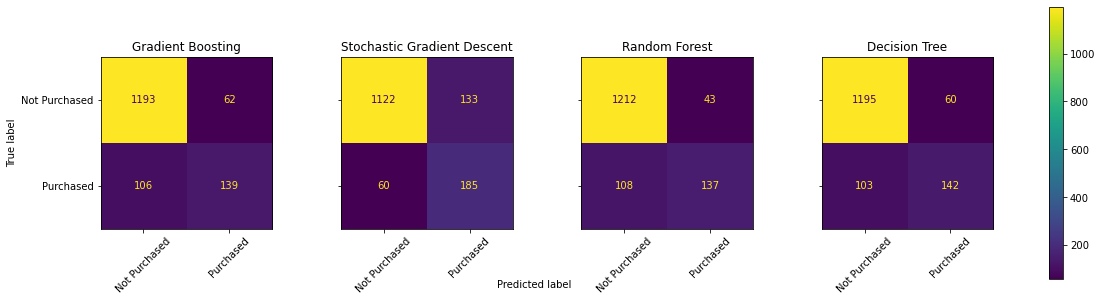

In [22]:
# Side by side comparison with the 4 best performing classifiers

classifiers = {
    "Gradient Boosting": gs_gbm,
    "Stochastic Gradient Descent": gs_sgd,
    "Random Forest": gs_rf,
    "Decision Tree": gs_dt
}

f, axes = plt.subplots(1, 4, figsize=(20, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    print(key, " \n Accuracy:",accuracy_score(y_test,y_pred),"\n f1 score",f1_score(y_test,y_pred))
    disp = ConfusionMatrixDisplay(cf_matrix,
                                  display_labels=["Not Purchased","Purchased"])
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)


f.colorbar(disp.im_, ax=axes)
plt.show()

In [24]:
# Combination of the three best models
estimators=[('Random Forest',gs_rf),('Decision Tree',gs_dt),('Stochastic Gradient Descent',gs_sgd)]
ensemble = VotingClassifier(estimators, voting='hard')
ensemble.fit(X_train, y_train)
y_pred = ensemble.fit(X_train, y_train).predict(X_test)
print(" Accuracy : ",accuracy_score(y_test,y_pred),"\n f1 score",f1_score(y_test,y_pred))

 Accuracy :  0.8986666666666666 
 f1 score 0.6724137931034483


# STEP 7 : Export

## Exporting files for the API

In [82]:
pickle.dump(ensemble, open('Flask_restful_api/model.pickle', 'wb'))
pickle.dump(scalar, open('Flask_restful_api/scaler.pickle','wb'))
pickle.dump(column_trans, open('Flask_restful_api/column_trans.pickle','wb'))